In [1]:
import math

import numpy as np
import qiskit.quantum_info
from sympy import *
import random
from qiskit import *
from qiskit import IBMQ
import pylatexenc
import scipy as sp
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
from IPython.display import clear_output
from numpy import linalg as la
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.circuit import Parameter
from qiskit.compiler import transpile, assemble
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.visualization import *
from operator import itemgetter
from functools import reduce
import pickle

In [4]:
file = open("key2.txt", "r")
key = file.read()
IBMQ.save_account(key, overwrite='True')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')
# provider = IBMQ.get_provider

print(provider.backends())

backendJakarta = provider.get_backend('ibmq_jakarta')
backendCasablanca = provider.get_backend('ibmq_casablanca')
backendQuito = provider.get_backend('ibmq_quito')
backendBelem = provider.get_backend('ibmq_belem')
backendQASM = provider.get_backend('ibmq_qasm_simulator')
# backend = provider.get_backend('simulator_statevector')
# simulator = Aer.get_backend('aer_simulator')
backend = backendJakarta
print(backend)
jobManager = IBMQJobManager()

ibmqfactory.load_account:WARNING:2021-11-06 23:46:54,118: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_casablanca') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q-research', group='michstate-4', project='main')>, <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q-research', group='michstate-4',

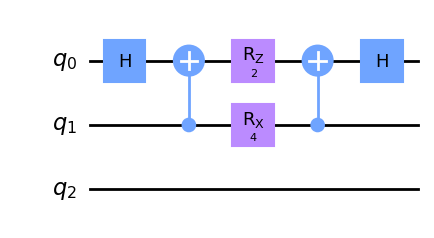

In [5]:
#turn on hadamards to get all 4 states present
def make_cont_sys_circ(inTime, xMod, zMod):
    temp = QuantumCircuit(3)

    temp.h(0)

    temp.cx(1, 0)

    temp.rx(2 * xMod * inTime, 1)
    temp.rz(2 * zMod * inTime, 0)

    temp.cx(1, 0)

    temp.h(0)

    return temp

temp = QuantumCircuit(3)

temp.compose(make_cont_sys_circ(1, 2, 1), [0, 1, 2], inplace=True)

temp.draw('mpl')

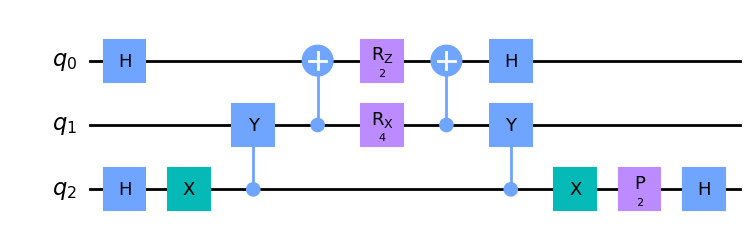

In [7]:
def make_cycle(time, ETarget, xMod, zMod):
    cycle = QuantumCircuit(3)

    cycle.h(2)

    cycle.x(2)
    cycle.cy(2, 1)

    cycle.compose(make_cont_sys_circ(time, xMod, zMod), [0, 1, 2], inplace=True)

    cycle.cy(2, 1)
    cycle.x(2)

    cycle.p(time * ETarget * 2, 2)

    cycle.h(2)

    return cycle

test = QuantumCircuit(3)
test.compose(make_cycle(1, 1, 2, 1), [0, 1, 2], inplace=True)
test.draw('mpl')

In [8]:
def run_rodeo(times, numCycles, ETarget, xMod, zMod, twoStateTime = None):
    # debug printing
    # if twoStateTime is None:
    #     print('running energy = ' + str(ETarget))
    # else:
    #     print('running energy = ' + str(ETarget) + '; second time evolve is: ' + str(twoStateTime))

    rodeo = QuantumCircuit(QuantumRegister(3), ClassicalRegister(numCycles + 1))

    for i in range(numCycles):
        rodeo.compose(make_cycle(times[i], ETarget, xMod, zMod), [0, 1, 2], inplace=True)
        rodeo.measure(2, i + 1)

    if twoStateTime is not None:
        rodeo.compose(make_cont_sys_circ(twoStateTime, xMod, zMod), [0, 1, 2], inplace=True)
        rodeo.measure(1, 0)

    return rodeo

# old code from before job manager
# job = execute(rodeo, backend=backend)
# job.wait_for_final_state()
# state = '0'
# for i in range(numCycles):
#     state = state + '0'
#
# return job.result().get_counts().get(state)

In [9]:
#TODO: make threshold rigorous

def search_spectrum(linspace, threshold, numCycles, laterScanNum, numSecond, xMod, zMod, backend = provider.get_backend('ibmq_belem')):
    delta = abs(linspace[1]) - abs(linspace[0])
    length = linspace[0] - linspace[-1]

    runResults = list()
    energyList = list()

    state = '0'
    for i in range(numCycles):
        state = state + '0'
    jobManager = IBMQJobManager()

    peaks = list()
    firstRunCircs = list()
    for i in linspace:
        times = []
        for j in range(numCycles):
            times.append(np.random.normal(0, 2))
        firstRunCircs.append(run_rodeo(times, numCycles, i, xMod, zMod))
    print("first pass w/ energies")
    print(linspace)
    firstRunCircs = transpile(firstRunCircs, backend=backend)
    firstRunJob = jobManager.run(firstRunCircs, backend=backend, name = "first_pass")
    firstRunResults = firstRunJob.results()
    runResults.append(firstRunResults)
    energyList.append(linspace)

    for runNum in range(linspace.size):
        if firstRunResults.get_counts(runNum).get(state) is not None and firstRunResults.get_counts(runNum).get(state) >= threshold:
            peaks.append(linspace[runNum])
    print("second pass w/ peaks:")
    print(peaks)

    secondRunCircs = list()
    energyList.append([])
    for i in peaks:
        for j in np.linspace(i - delta/2, i + delta/2, laterScanNum):
            for num in range(numSecond):
                times = []
                for k in range(numCycles):
                    times.append(np.random.normal(0, 7))
                # print('energy: ' + str(j))
                secondRunCircs.append(run_rodeo(times, numCycles, j, xMod, zMod))
                energyList[1].append(j)

    secondRunCircs = transpile(secondRunCircs, backend=backend)
    secondRunJob = jobManager.run(secondRunCircs, backend=backend, name = "second_run")

    runResults.append(secondRunJob.results())
    print("done w/ second pass")

    return [runResults, energyList, state, [11, laterScanNum], [1, numSecond]]

In [10]:
#this code is genuinely terrible, but it works
#runNumber is 0 indexed
def process_data(output, runNumber):
    pairArray = []
    for i in range(int(len(output[1][runNumber]) / (output[4][runNumber]))):
        totalSuccess = 0
        for j in range(output[4][runNumber]):
            if output[0][runNumber].get_counts(i * output[4][runNumber] + j).get(output[2]) is not None:
                totalSuccess = totalSuccess + output[0][runNumber].get_counts(i * output[4][runNumber] + j).get(output[2])
        pairArray.append([output[1][runNumber][i * output[4][runNumber]], totalSuccess / output[4][runNumber]])

    subScans = []
    for i in range(int(len(pairArray) / output[3][runNumber])):
        temp = []
        for k in range(output[3][runNumber]):
            temp.append(pairArray[k + i * output[3][runNumber]])
        temp.reverse()
        subScans.append(temp)
    return subScans

In [11]:
def plot_scans(data):
    energy = []
    successes = []
    for i in data:
        for j in i:
            energy.append(j[0])
            if j[1] is not None:
                successes.append(j[1])

    hist1 = plt.bar(energy, successes, width=(0.8*(energy[1]-energy[0])))
    plt.show()

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -1.0, 2.0, 4.0, 5.0]
done w/ second pass
2
[[[-4.5, 88.44], [-4.45, 147.12], [-4.4, 117.24], [-4.35, 119.32], [-4.3, 143.84], [-4.25, 99.52], [-4.2, 114.64], [-4.15, 187.32], [-4.1, 82.8], [-4.05, 145.68], [-4.0, 168.24], [-3.95, 132.24], [-3.9, 169.0], [-3.85, 142.16], [-3.8, 79.76], [-3.75, 123.36], [-3.7, 120.84], [-3.65, 122.28], [-3.6, 145.12], [-3.55, 142.92], [-3.5, 88.2]], [[-1.5, 148.44], [-1.4500000000000002, 168.0], [-1.4, 160.12], [-1.35, 142.64], [-1.3, 119.52], [-1.25, 164.48], [-1.2000000000000002, 104.84], [-1.15, 160.64], [-1.1, 205.08], [-1.05, 457.28], [-1.0, 616.48], [-0.95, 415.48], [-0.9, 216.08], [-0.8500000000000001, 145.44], [-0.8, 127.8], [-0.75, 60.36], [-0.7, 129.16], [-0.65, 160.24], [-0.6, 92.6], [-0.55, 112.6], [-0.5, 144.76]], [[1.5, 147.04], [1.5499999999999998, 194.48], [1.6, 94.68], [1.65, 144.88], [1.7, 148.24], [1.75, 100.08], [1.7999999999999998, 172.2

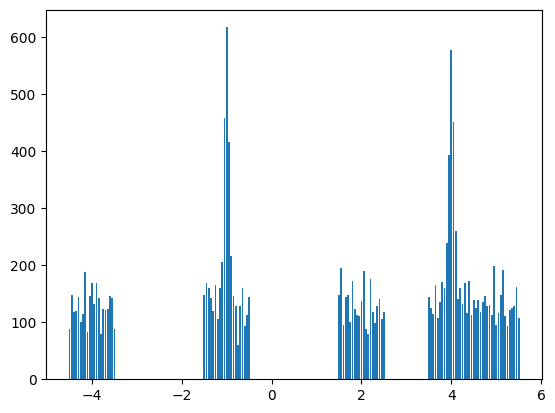

In [14]:
threeCycleOut = search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, 2.5, 1.5)
# print(threeCycleOut)
print(len(threeCycleOut[1][1]))
threeCycle2 = process_data(threeCycleOut, 1)
print(threeCycle2)

plot_scans(threeCycle2)

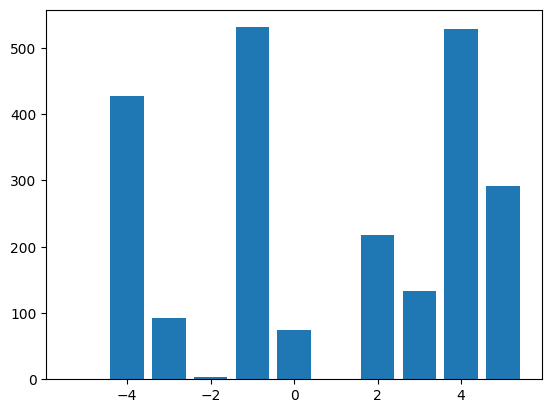

In [15]:
threeCycle1 = process_data(threeCycleOut, 0)
plot_scans(threeCycle1)

In [12]:
xmod1 = 1#.3359430644
zmod1 = 2.7803609513

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, 0.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-2.5, 140.52], [-2.45, 151.12], [-2.4, 174.28], [-2.35, 101.96], [-2.3, 79.08], [-2.25, 131.04], [-2.2, 117.12], [-2.15, 127.08], [-2.1, 120.2], [-2.05, 114.64], [-2.0, 109.2], [-1.95, 113.96], [-1.9, 157.6], [-1.85, 154.84], [-1.8, 162.96], [-1.75, 205.48], [-1.7, 138.24], [-1.65, 119.72], [-1.6, 142.76], [-1.55, 175.4], [-1.5, 107.28]], [[-0.5, 79.0], [-0.45000000000000007, 71.92], [-0.4, 146.88], [-0.3500000000000001, 97.8], [-0.30000000000000004, 120.96], [-0.25, 127.6], [-0.20000000000000007, 100.96], [-0.15000000000000002, 112.64], [-0.10000000000000009, 119.56], [-0.050000000000000044, 118.64], [0.0, 126.76], [0.04999999999999999, 132.92], [0.09999999999999998, 104.52], [0.14999999999999997, 156.72], [0.19999999999999996, 111.4], [0.25, 66.16], [0.3, 110.8], [0.35, 149.96], [0.4, 114.0], [0.45, 112.44], [0.5, 124.92]], [[1.5, 120.52], 

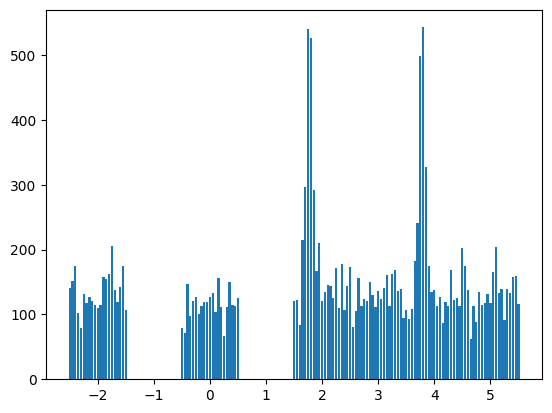

In [18]:
randomTest = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTest)
plot_scans(randomTest)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, -1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-22 15:10:56,110: Job limit reached, waiting for job 61730cb5731fe680eebce245 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:13:57,821: Job limit reached, waiting for job 61730cb8976ff9693281c634 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:28,294: Job limit reached, waiting for job 61730cba976ff983b481c635 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:14:56,945: Job limit reached, waiting for job 61730cbc976ff9bfea81c636 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:29,063: Job limit reached, waiting for job 61730cbe706f42c99d432c01 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-22 15:15:59,461: Job limit reached, waiting for job 61730d73731fe6551cbce24a to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-5.5, 129.12], [-5.45, 165.8], [-5.4, 127.2], [-5.35, 111.0], [-5.3, 124.8], [-5.25, 130.16], [-5.2, 144.2], [-5.15, 144.24], [-5.1, 171.32], [-5.05, 141.12], [-5.0, 156.4], [-4.95, 146.72], [-4.9, 127.2], [-4.85, 131.16], [-4.8, 120.8], [-4.75, 127.8], [-4.7, 153.56], [-4.65, 135.88], [-4.6, 134.36], [-4.55, 123.16], [-4.5, 144.32]], [[-2.5, 149.16], [-2.45, 147.88], [-2.4, 108.6], [-2.35, 149.48], [-2.3, 155.72], [-2.25, 114.36], [-2.2, 148.56], [-2.15, 147.96], [-2.1, 133.28], [-2.05, 172.88], [-2.0, 112.44], [-1.95, 113.52], [-1.9, 124.64], [-1.85, 134.32], [-1.8, 166.96], [-1.75, 185.36], [-1.7, 168.2], [-1.65, 139.52], [-1.6, 169.16], [-1.55, 105.76], [-1.5, 129.2]], [[-1.5, 138.36], [-1.4500000000000002, 135.2], [-1.4, 142.44], [-1.35, 132.88], [-1.3, 120.6], [-1.25, 151.44], [-1.2000000000000002, 165.28], [-1.15, 119.56], [-1.1, 154.08], [-1.05, 113.72], [-1.0, 153.44], [-0.95, 148.28], [-0.9, 130.16], [-0.8500000000000001, 160.4], [-0.8, 165.08], [-0.75,

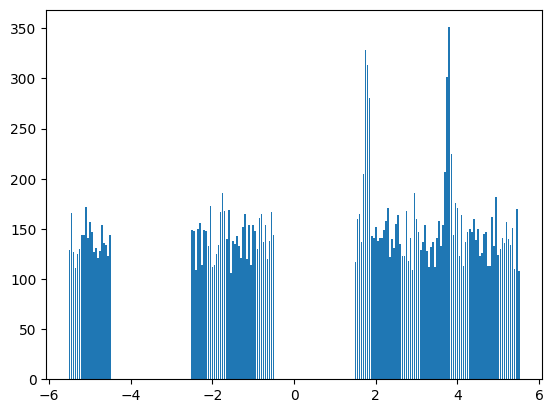

In [20]:
randomTestQ = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestQ)
plot_scans(randomTestQ)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-4.0, -2.0, -1.0, 1.0, 2.0, 3.0, 4.0, 5.0]


managedjob._async_submit:WARNING:2021-10-24 00:52:39,735: Job limit reached, waiting for job 6174e68d731fe62419bcf1b5 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:14,194: Job limit reached, waiting for job 6174e68f706f426d59433b60 to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:53:43,384: Job limit reached, waiting for job 6174e6909e07dd733b57995b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:11,400: Job limit reached, waiting for job 6174e6924829a00a7616262b to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:54:39,980: Job limit reached, waiting for job 6174e6946ab940b0d710ed9d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10-24 00:55:08,083: Job limit reached, waiting for job 6174e6b69e07ddb09257995d to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-10

done w/ second pass
[[[-4.5, 250.92], [-4.45, 243.44], [-4.4, 314.52], [-4.35, 259.6], [-4.3, 207.16], [-4.25, 302.76], [-4.2, 245.92], [-4.15, 274.44], [-4.1, 253.52], [-4.05, 262.0], [-4.0, 271.2], [-3.95, 251.2], [-3.9, 230.48], [-3.85, 270.8], [-3.8, 267.64], [-3.75, 298.68], [-3.7, 298.36], [-3.65, 244.88], [-3.6, 209.24], [-3.55, 329.04], [-3.5, 336.72]], [[-2.5, 273.36], [-2.45, 258.12], [-2.4, 312.72], [-2.35, 316.96], [-2.3, 323.68], [-2.25, 266.4], [-2.2, 261.72], [-2.15, 283.08], [-2.1, 297.24], [-2.05, 280.36], [-2.0, 241.08], [-1.95, 275.68], [-1.9, 243.16], [-1.85, 281.92], [-1.8, 287.96], [-1.75, 253.88], [-1.7, 226.16], [-1.65, 278.4], [-1.6, 282.16], [-1.55, 314.64], [-1.5, 262.12]], [[-1.5, 243.6], [-1.4500000000000002, 256.92], [-1.4, 333.04], [-1.35, 290.84], [-1.3, 301.04], [-1.25, 270.52], [-1.2000000000000002, 282.64], [-1.15, 264.28], [-1.1, 310.84], [-1.05, 277.12], [-1.0, 328.56], [-0.95, 308.56], [-0.9, 262.68], [-0.8500000000000001, 316.16], [-0.8, 243.32], 

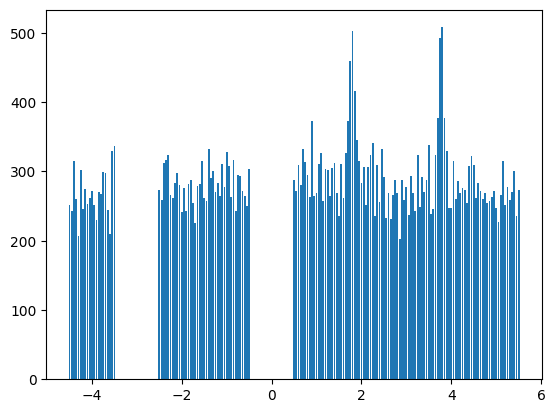

In [12]:
randomTestQ2 = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 2, 21, 25, xmod1, zmod1), 1)
print(randomTestQ2)
plot_scans(randomTestQ2)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-5.0, -2.0, 0.0, 1.0, 2.0, 4.0]
done w/ second pass
[[[-5.5, 122.76], [-5.45, 143.56], [-5.4, 101.76], [-5.35, 159.52], [-5.3, 137.76], [-5.25, 123.12], [-5.2, 136.6], [-5.15, 147.0], [-5.1, 116.64], [-5.05, 156.88], [-5.0, 127.36], [-4.95, 125.4], [-4.9, 183.44], [-4.85, 139.28], [-4.8, 120.8], [-4.75, 123.8], [-4.7, 145.48], [-4.65, 96.32], [-4.6, 136.36], [-4.55, 108.64], [-4.5, 111.08]], [[-2.5, 112.84], [-2.45, 161.72], [-2.4, 121.68], [-2.35, 142.88], [-2.3, 106.36], [-2.25, 107.32], [-2.2, 135.8], [-2.15, 106.4], [-2.1, 172.64], [-2.05, 99.44], [-2.0, 143.36], [-1.95, 123.12], [-1.9, 147.0], [-1.85, 100.64], [-1.8, 164.6], [-1.75, 174.52], [-1.7, 159.52], [-1.65, 137.04], [-1.6, 134.88], [-1.55, 139.6], [-1.5, 143.48]], [[-0.5, 108.84], [-0.45000000000000007, 147.24], [-0.4, 120.4], [-0.3500000000000001, 149.56], [-0.30000000000000004, 110.28], [-0.25, 116.52], [-0.20000000000000007, 152.

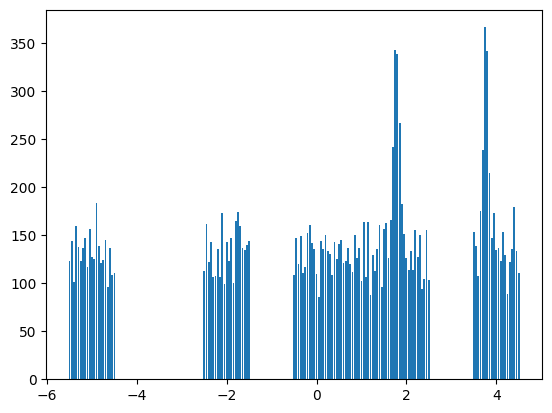

In [19]:
randomTestCasablanca = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestCasablanca)
plot_scans(randomTestCasablanca)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-3.0, 1.0, 2.0, 3.0, 4.0, 5.0]
done w/ second pass
[[[-3.5, 166.32], [-3.45, 106.68], [-3.4, 131.28], [-3.35, 173.36], [-3.3, 144.44], [-3.25, 114.56], [-3.2, 136.72], [-3.15, 149.04], [-3.1, 111.2], [-3.05, 121.4], [-3.0, 104.16], [-2.95, 127.12], [-2.9, 136.4], [-2.85, 131.96], [-2.8, 113.72], [-2.75, 99.44], [-2.7, 132.6], [-2.65, 99.88], [-2.6, 126.16], [-2.55, 118.24], [-2.5, 128.72]], [[0.5, 141.76], [0.5499999999999999, 141.52], [0.6, 151.96], [0.6499999999999999, 122.8], [0.7, 163.12], [0.75, 110.72], [0.7999999999999999, 127.44], [0.85, 178.0], [0.8999999999999999, 117.36], [0.95, 150.72], [1.0, 104.96], [1.05, 129.52], [1.1, 137.04], [1.15, 153.0], [1.2, 166.84], [1.25, 134.92], [1.3, 177.8], [1.35, 118.92], [1.4, 121.4], [1.45, 133.76], [1.5, 140.04]], [[1.5, 124.32], [1.5499999999999998, 140.92], [1.6, 157.4], [1.65, 210.48], [1.7, 220.44], [1.75, 320.16], [1.7999999999999998, 347.8]

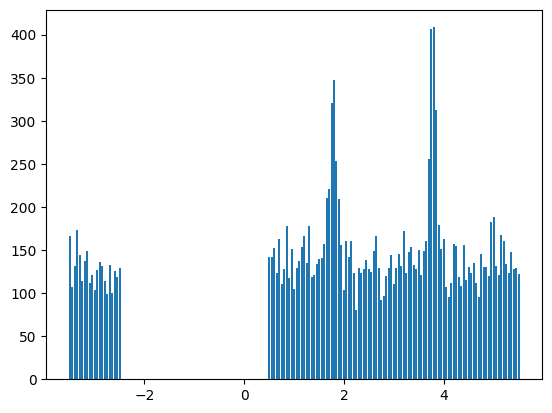

In [21]:
randomTestJakarta = process_data(search_spectrum(np.linspace(-5, 5, 11), 150, 3, 21, 25, xmod1, zmod1), 1)
print(randomTestJakarta)
plot_scans(randomTestJakarta)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677D7C5340>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677E781880>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.45, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.4, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.35, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 2.3, 

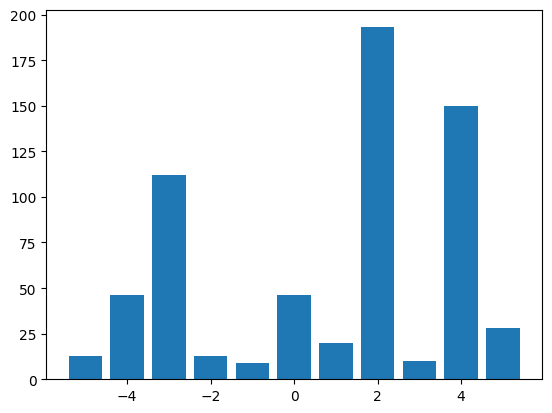

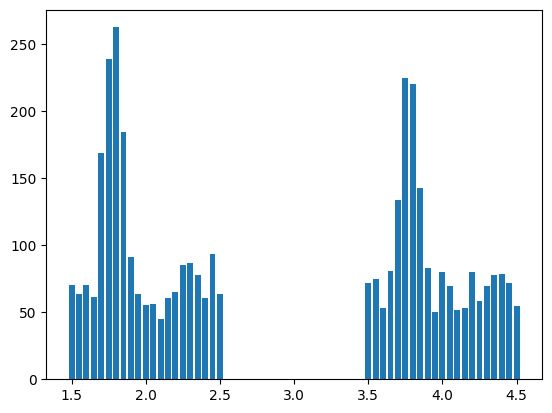

In [14]:
randomTestJakarta4Cycle = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial = process_data(randomTestJakarta4Cycle, 0)
randomTestJakarta4CycleFinal = process_data(randomTestJakarta4Cycle, 1)
print(randomTestJakarta4Cycle)
plot_scans(randomTestJakarta4CycleInitial)
plot_scans(randomTestJakarta4CycleFinal)

first pass w/ energies
[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
second pass w/ peaks:
[-2.0, -1.0, 2.0, 4.0]
done w/ second pass
[[<qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002677EA93AC0>, <qiskit.providers.ibmq.managed.managedresults.ManagedResults object at 0x000002671AF84D60>], [array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), [-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.55, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.6, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65, -1.65

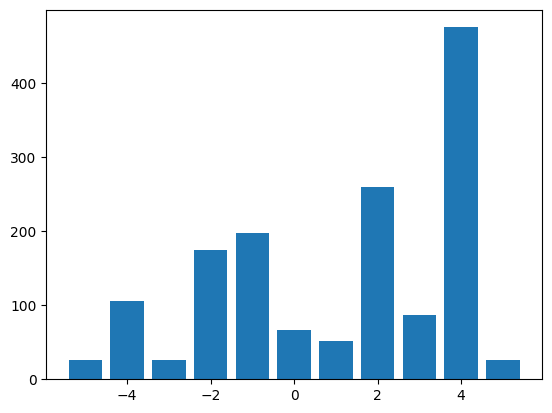

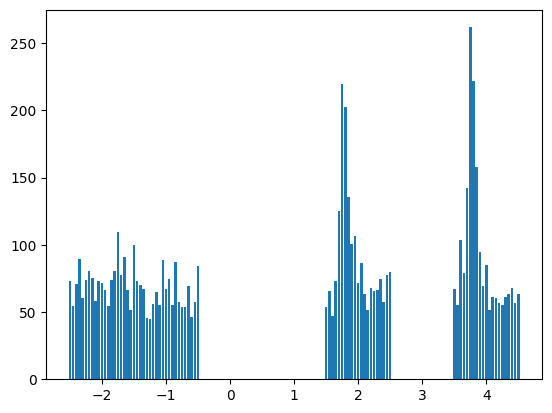

In [15]:
randomTestJakarta4Cycle2 = search_spectrum(np.linspace(-5, 5, 11), 150, 4, 21, 25, xmod1, zmod1)
randomTestJakarta4CycleInitial2 = process_data(randomTestJakarta4Cycle2, 0)
randomTestJakarta4CycleFinal2 = process_data(randomTestJakarta4Cycle2, 1)
print(randomTestJakarta4Cycle2)
plot_scans(randomTestJakarta4CycleInitial2)
plot_scans(randomTestJakarta4CycleFinal2)

In [13]:
jobManager = IBMQJobManager()
twoStateCircs = list()
times = list()
for i in range(3):
    times.append(random.randrange(1, 5) * 2 * 3.1415926 / (4 - -1))

for i in range(100):
    twoStateCircs.append(run_rodeo(times, 3, -1, 2.5, 1.5, i/10))

twoStateCircs[0].draw()
twoStateCircs = transpile(twoStateCircs, backend=backend)
twoStateJob = jobManager.run(twoStateCircs, backend=backend, name = "two_state_test")
twoStateResults = twoStateJob.results()
print(twoStateResults)

[405, 364, 275, 210, 137, 70, 24, 36, 89, 162, 257, 289, 342, 328, 312, 265, 172, 85, 38, 25, 67, 116, 200, 259, 345, 378, 364, 278, 232, 143, 80, 25, 28, 56, 135, 233, 287, 349, 367, 348, 252, 165, 100, 52, 21, 58, 121, 195, 283, 339, 354, 353, 298, 259, 155, 87, 35, 22, 71, 140, 214, 296, 326, 345, 340, 257, 186, 112, 64, 30, 40, 102, 200, 267, 336, 354, 361, 307, 244, 161, 91, 46, 41, 67, 142, 219, 285, 339, 361, 338, 289, 217, 144, 54, 32, 40, 97, 145, 225, 292]


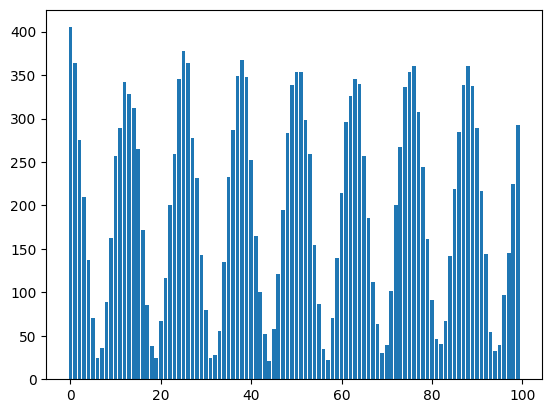

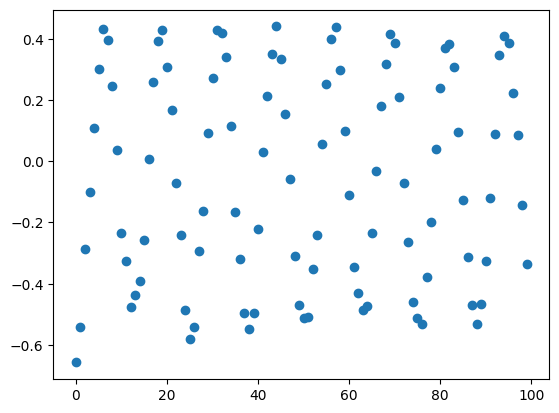

In [16]:
results = list()

for i in range(100):
    if twoStateResults.get_counts(i).get('0000') is not None:
        results.append(twoStateResults.get_counts(i).get('0000'))
    else:
        results.append(0)

print(results)

expectations = list()

for i in results:
    expectations.append(i/350 * -0.5 + (350-i)/350 * 0.5)

plt.bar(range(100), results)
plt.show()

plt.scatter(range(100), expectations)
plt.show()

In [14]:
simBackend = provider.get_backend('ibmq_qasm_simulator')
twoStateCircsSim = list()
timesSim = list()
jobManager = IBMQJobManager()
for i in range(3):
    timesSim.append(random.randrange(1, 5) * 2 * 3.1415926 / (4 - -1))

for i in range(100):
    twoStateCircsSim.append(run_rodeo(timesSim, 3, -1, 2.5, 1.5, i/10))

twoStateCircsSim[0].draw()
twoStateCircsSim = transpile(twoStateCircsSim, backend=simBackend)
twoStateJobSim = jobManager.run(twoStateCircsSim, backend=simBackend, name = "two_state_test")
twoStateResultsSim = twoStateJobSim.results()
print(twoStateResultsSim)

TypeError: cannot pickle '_thread.RLock' object

[543, 501, 554, 534, 550, 552, 525, 527, 560, 513, 538, 519, 538, 542, 510, 535, 511, 526, 525, 520, 529, 552, 538, 543, 505, 518, 519, 517, 550, 508, 542, 551, 546, 531, 549, 535, 532, 528, 539, 553, 538, 555, 519, 546, 545, 532, 541, 538, 521, 503, 541, 502, 509, 544, 518, 567, 521, 545, 535, 519, 547, 552, 548, 530, 527, 520, 514, 521, 532, 523, 528, 521, 550, 537, 525, 552, 531, 539, 524, 542, 502, 530, 528, 512, 532, 539, 540, 544, 513, 509, 539, 534, 553, 545, 537, 567, 527, 530, 523, 525]
[543, 456, 438, 273, 174, 55, 2, 16, 91, 213, 356, 446, 527, 535, 435, 355, 225, 102, 17, 0, 36, 139, 264, 400, 463, 518, 488, 396, 321, 148, 64, 5, 6, 86, 186, 324, 431, 517, 537, 502, 375, 268, 117, 32, 0, 29, 144, 246, 373, 449, 538, 488, 433, 340, 175, 79, 14, 12, 74, 167, 304, 447, 530, 529, 493, 392, 275, 128, 32, 0, 31, 114, 241, 358, 474, 549, 522, 455, 324, 215, 92, 13, 4, 49, 146, 286, 424, 518, 513, 484, 426, 299, 140, 37, 1, 20, 92, 206, 354, 446]


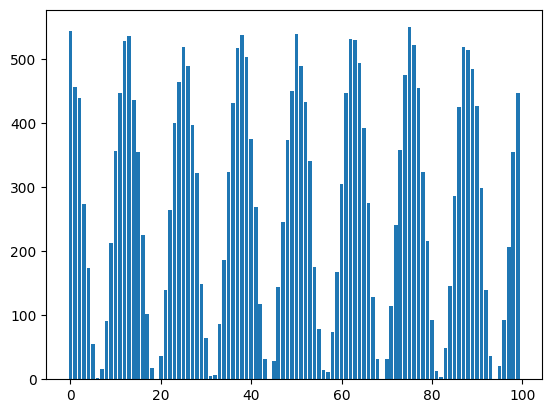

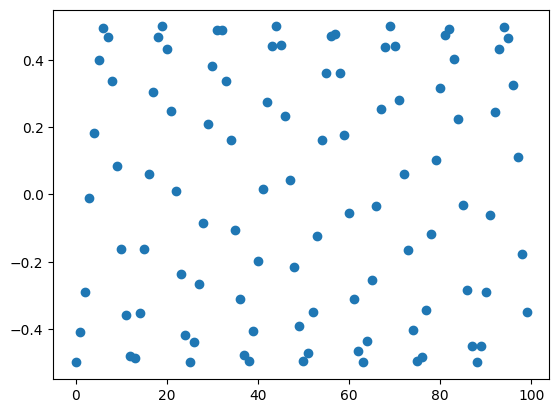

In [31]:
resultsSim = list()
totals = list()

for i in range(100):
    temp = 0
    if twoStateResultsSim.get_counts(i).get('0000') is not None:
        temp = twoStateResultsSim.get_counts(i).get('0000')
        if twoStateResultsSim.get_counts(i).get('0001') is not None:
            temp = temp + twoStateResultsSim.get_counts(i).get('0001')
    elif twoStateResultsSim.get_counts(i).get('0001') is not None:
        temp = twoStateResultsSim.get_counts(i).get('0001')
    totals.append(temp)
    temp = 0

print(totals)

for i in range(100):
    if twoStateResultsSim.get_counts(i).get('0000') is not None:
        resultsSim.append(twoStateResultsSim.get_counts(i).get('0000'))
    else:
        resultsSim.append(0)

print(resultsSim)

expectationsSim = list()

plt.bar(range(100), resultsSim)
plt.show()

for i in range(100):
    expectationsSim.append(resultsSim[i]/totals[i] *(-0.5) + (1-resultsSim[i]/totals[i]) * 0.5)



plt.scatter(range(100), expectationsSim)
plt.show()

In [11]:
def process_two_state(results, state):
    totals = list()
    counts = list()
    expectations = list()

    for i in range(100):
        temp = 0
        if results.get_counts(i).get(state) is not None:
            temp = results.get_counts(i).get(state)
            if results.get_counts(i).get(state[:-1] + '1') is not None:
                temp = temp + results.get_counts(i).get(state[:-1] + '1')
        elif results.get_counts(i).get(state[:-1] + '1') is not None:
            temp = results.get_counts(i).get(state[:-1] + '1')
        totals.append(temp)
        temp = 0

    for i in range(100):
        if results.get_counts(i).get(state) is not None:
            counts.append(results.get_counts(i).get(state))
        else:
            counts.append(0)

    for i in range(100):
        expectations.append(counts[i]/totals[i] * (-0.5) + (1-counts[i]/totals[i]) * 0.5)

    return expectations

In [30]:
#todo: make random times proper

def run_two_cycle(cycles, secondTimes, xMod, zMod, lowTarget, highTarget, backend = provider.get_backend('ibmq_belem')):
    times = list()
    for i in range(cycles):
        times.append(random.randrange(1, 5) * 2 * 3.1415926 / (highTarget - lowTarget))
    circs = list()
    for i in secondTimes:
        circs.append(run_rodeo(times, cycles, lowTarget, xMod, zMod, i))

    circs = transpile(circs, backend=backend)
    job = jobManager.run(circs, backend=backend, name="two_state")

    return job

In [14]:
twoStateCircsTest = list()
timesTest = list()

for i in range(3):
    timesTest.append(random.randrange(1, 5) * 2 * 3.1415926 / (4 - -1))

for i in range(100):
    twoStateCircsTest.append(run_rodeo(timesTest, 3, -1, 2.5, 1.5, i/10))

twoStateCircsTest = transpile(twoStateCircsTest, backend=backend)
twoStateJobTest = jobManager.run(twoStateCircsTest, backend=backend, name = "two_state_test")
twoStateResultsTest = twoStateJobTest.results()
print(twoStateJobTest.job_set_id())

0df6d21336f642f2a7bdefe38af54efc-1636139099915199


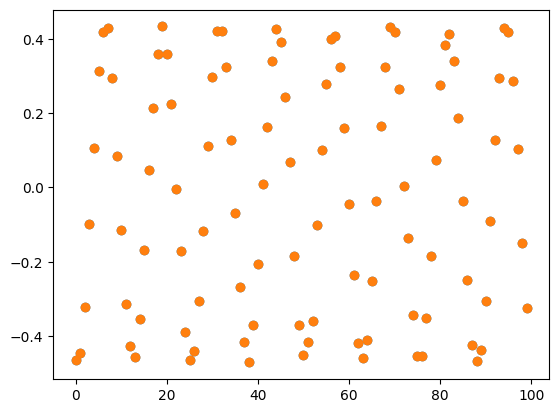

In [17]:
plt.scatter(range(100), process_two_state(twoStateResultsTest, "0000"))
plt.show()

In [31]:
fourRange = list(range(100))
fourRange[:] = [x / 25 for x in fourRange]

fourJob = run_two_cycle(3, fourRange, 2.5, 1.5, -1, 4)
print(fourJob.job_set_id())
fourResults = fourJob.results()

eb379bacddad4a89a4efef94e987f0bd-1636140982352417


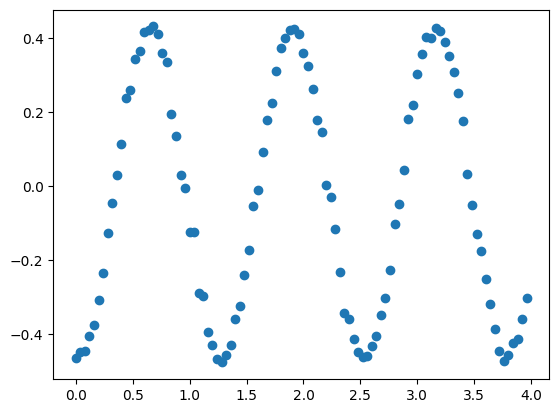

In [32]:
plt.scatter(fourRange, process_two_state(fourResults, "0000"))
plt.show()

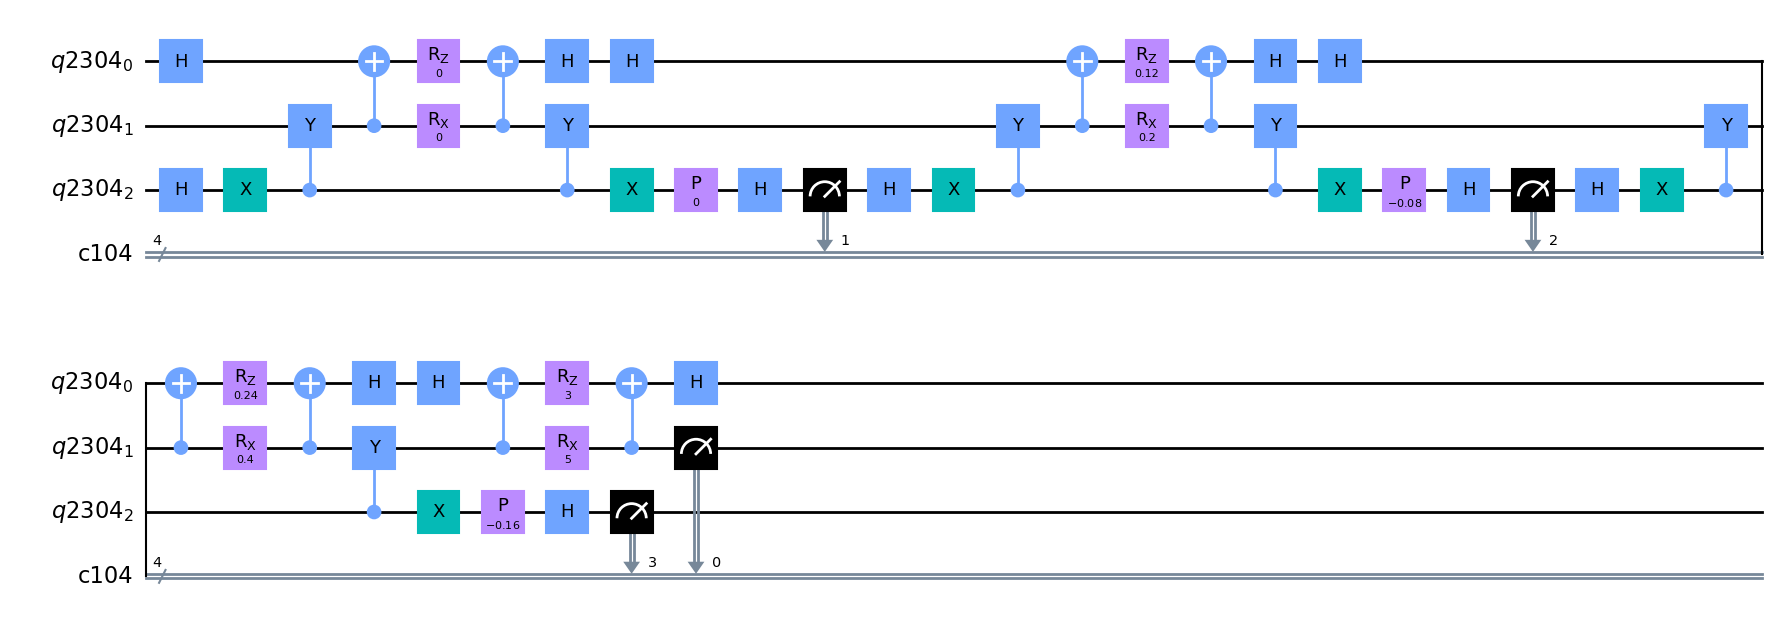

In [25]:
circ = run_rodeo(fourRange, 3, -1, 2.5, 1.5, 1)
circ.draw('mpl')